# The Metropolis Algorithm
## Packages and Config

In [1]:
include("Metropolis.jl");
using StatsPlots, LaTeXStrings, StatsBase, LinearAlgebra, Distributions
figpath = "../fig/"
Plots.default(lw=3, ms=5, legend=false, fontfamily="Computer Modern",
    titlefontsize=18, tickfontsize=10, labelfontsize=14, legendfontsize=10)

## Distribution

In [2]:
series, seriesaccept = Metropolis.metropolis_uniform(x -> ℯ^(-x^2/2), 3, 100000000)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.10844950275018306, -0.10844950275018306, -0.10844950275018306  …  0.2561907873450431, 0.2561907873450431, 0.2561907873450431, 0.2561907873450431, 1.0016702033080693, 1.0016702033080693, -1.827332620612724, -1.827332620612724, 0.30908512103184727, 0.30908512103184727], 0.49292660492926604)

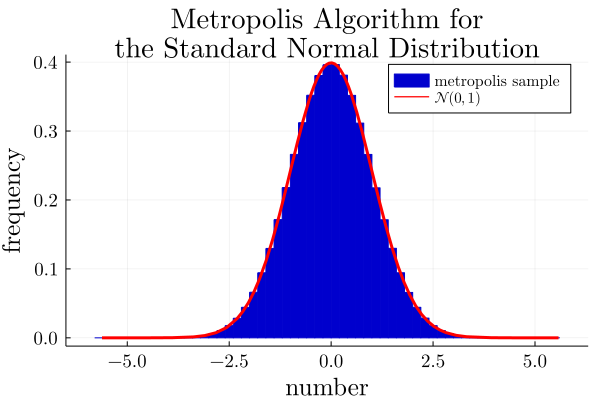

In [3]:
hist = normalize(fit(Histogram, series, nbins=60), mode=:pdf)

p = plot(hist, lw=:auto, color=:mediumblue, lc=:match,
    legend=true, label="metropolis sample",
    xlabel="number", ylabel="frequency",
    title="Metropolis Algorithm for\nthe Standard Normal Distribution",
    legendfontsize=10, labelfontsize=16, tickfontsize=12)
plot!(p, Normal(0, 1), minimum(series), maximum(series), color=:red, label=L"\mathcal{N}(0, 1)")

savefig(p, figpath * "metropolis-hist.pdf")
display(p)

## Acceptance Rate

In [4]:
stepsizes = collect(range(0.5, 15.9, length=1001))
acceptance = Float64[]

for s in stepsizes
    push!(acceptance, Metropolis.metropolis_uniform(x -> ℯ^(-x^2/2), s, 10000000)[2])
end

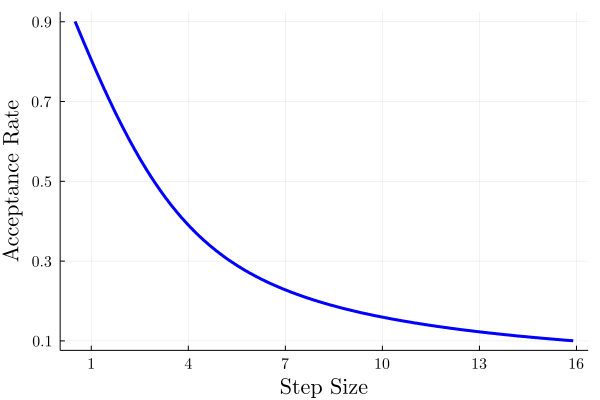

In [5]:
p = plot(stepsizes, acceptance, ylabel="Acceptance Rate", xlabel="Step Size", color=:blue,
    xticks=range(1, 16, step=3), yticks=range(0.1, 0.9, step=0.2))
savefig(p, figpath * "metropolis-acceptance.pdf")
display(p)

In [6]:
stepindex = [argmin(abs.(acceptance .- target)) for target in 0.1:0.1:0.9]
targetstep, targetaccept = stepsizes[stepindex], acceptance[stepindex]

([15.9, 7.9844, 5.3048, 3.888, 2.9486, 2.2094, 1.578, 1.0236, 0.5], [0.10026671002667101, 0.19991241999124199, 0.299864429986443, 0.400404240040424, 0.49902484990248497, 0.598802259880226, 0.700614070061407, 0.800205780020578, 0.900857290085729])

## Autocorrelation

In [7]:
accept = Float64[]
correlation = []
for step in targetstep
    metro = Metropolis.metropolis_uniform(x -> ℯ^(-x^2/2), step, 100000000)
    push!(correlation, autocor(metro[1]))
    push!(accept, metro[2])
end

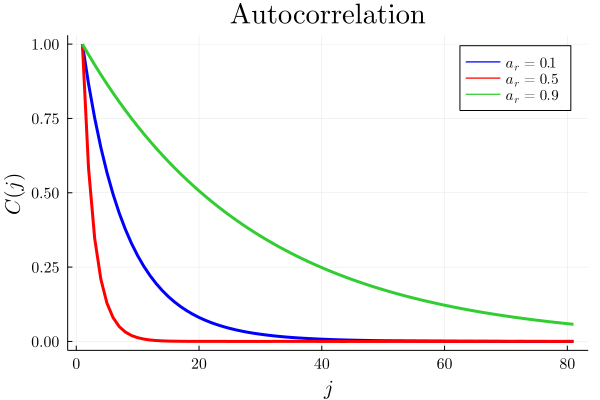

In [8]:
p = plot(correlation[[1, 5, 9]], palette=[:blue, :red, :limegreen], legend=true,
    labels = [L"a_r = 0.1" L"a_r = 0.5" L"a_r = 0.9"], title="Autocorrelation",
    xlabel=L"j", ylabel=L"C(j)")

savefig(p, figpath * "metropolis-autocor.pdf")
display(p)

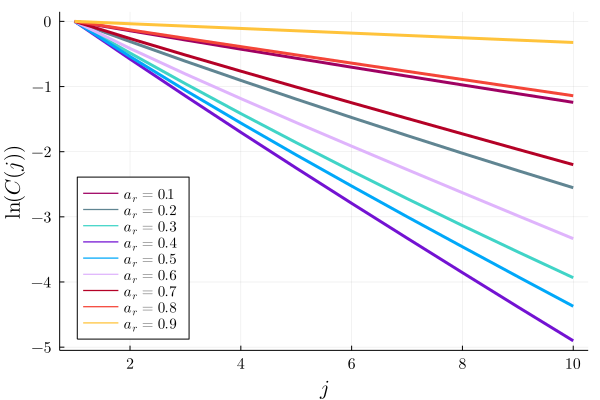

In [9]:
# cutoff correlation at 10 to avoid getting within floating-point error
correlationlog = [log.(cor[1:10]) for cor in correlation]

p = plot(correlationlog, palette=palette(:mk_12, 9),
    labels = reshape([L"a_r = %$i" for i in 0.1:0.1:0.9], (1, 9)), legend=:bottomleft,
    xlabel=L"j", ylabel=L"\mathrm{ln}(C(j))")

savefig(p, figpath * "metropolis-autocor-log.pdf")
display(p)

### Correlation Length

In [10]:
ξs = Float64[]
errors = Float64[]

x = collect(1:10)
for y in correlationlog
    ξ⁻¹, constant = hcat(x, ones(10)) \ y
    ξ = -1 / ξ⁻¹
    push!(ξs, ξ)

    errorξ⁻¹ = √(sum(t->t^2, y - ξ⁻¹ * x .- constant) / (8 * sum(t->t^2, x .- mean(x))))
    errorξ = errorξ⁻¹ / ξ⁻¹^2
    push!(errors, errorξ)
end

display(ξs)
display(errors)

9-element Vector{Float64}:
  7.243888727924722
  3.5309992899489795
  2.291474787138559
  1.8389571132284694
  2.0675837778927515
  2.716930614458392
  4.108300096200635
  7.894397580640802
 27.831461162584922

9-element Vector{Float64}:
 0.030578575095489936
 0.03237343117218046
 0.026276529863246557
 0.010703622195509473
 0.01988535504295718
 0.023240201105561437
 0.022499203746784067
 0.01907436291420527
 0.011666225296075618

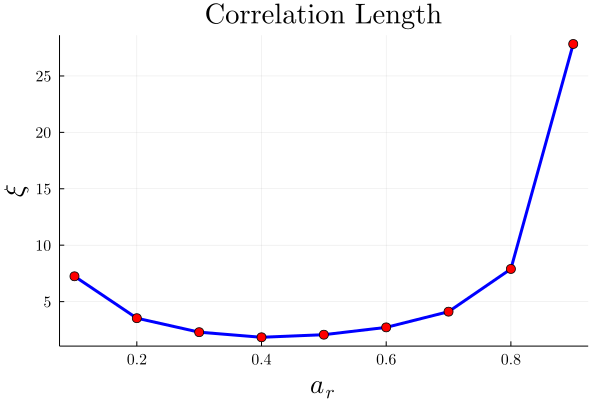

In [12]:
p = plot(0.1:0.1:0.9, ξs, marker=:circle, mc=:red, lc=:blue, labelfontsize=18,
    title="Correlation Length", xlabel=L"a_r", ylabel=L"\xi")

savefig(p, figpath * "metropolis-corlen.pdf")
display(p)